# Serie Temporal

https://www.vooo.pro/insights/guia-completo-para-criar-time-series-com-codigo-em-python/


In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 15,6
plt.style.use('ggplot')

In [53]:
data = pd.read_csv('datasets/AirPassengers.csv')
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [54]:
data.dtypes

Month          object
#Passengers     int64
dtype: object

In [55]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m') 
data = pd.read_csv('datasets/AirPassengers.csv', parse_dates=['Month'], index_col='Month',date_parser=dateparse) 
data.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [56]:
data.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [57]:
ts = data['#Passengers']
ts.head(10)

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
Name: #Passengers, dtype: int64

In [58]:
ts['1949-01-01']

112

In [59]:
ts['1949-01-01':'1949-05-01']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

In [60]:
ts['1949']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
1949-11-01    104
1949-12-01    118
Name: #Passengers, dtype: int64

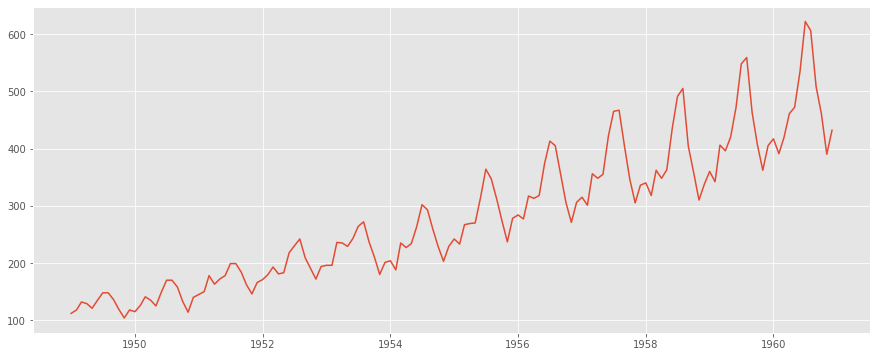

In [61]:
plt.plot(ts)

## Análise de série estacionaria.

A TS é dita estacionária se as suas propriedades estatísticas, tais como a média e variância permanecem constantes ao longo do tempo. Mas por que isso é importante? A maioria dos modelos TS trabalha com o pressuposto de que a TS é estacionária. Intuitivamente, podemos entender que se uma TS tem um comportamento particular ao longo de um tempo, há uma probabilidade muito elevada de que seguirá o mesmo comportamento no futuro. Além disso, as teorias relacionadas com séries estacionárias são mais maduras e mais fáceis de implementar, em comparação com séries não-estacionárias.

Estacionaridade (‘Stationarity’)  é definida usando critérios muito rigorosos. No entanto, para efeitos práticos, podemos assumir a série como estacionária se ela tiver propriedades estatísticas constantes ao longo do tempo. Ou seja, as seguintes:
Uma média constante
Uma variância constante
Uma autocovariância que não dependa do tempo

In [62]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):

    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    orig = plt.plot(timeseries, color = 'blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Média Móvel')
    std = plt.plot(rolstd, color='black', label='Desvio Padrão Móvel')
    plt.legend(loc='best')
    plt.title('Média e Desvio padrão móveis')
    plt.show(block=False)

    print('Resultados do teste Dickety-Fuller:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Teste Estatistico', 'p-value', '#Lags Used', 'Numero de observações'])
    for key, value in dftest[4].items():
        dfoutput['Valor crítico (%s)' % key] = value
    print(dfoutput)

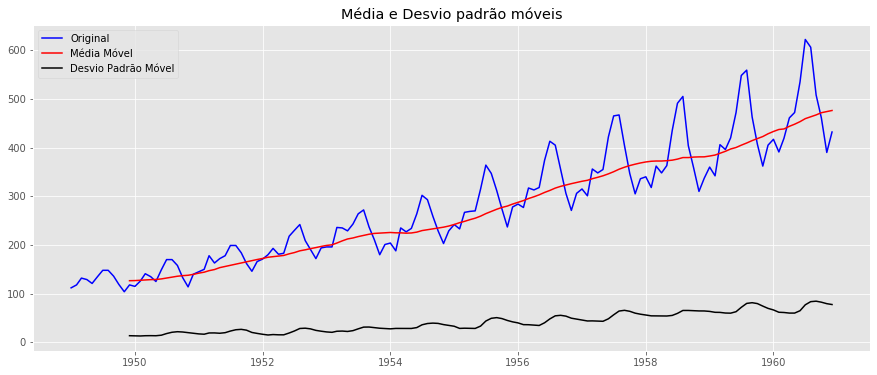

Resultados do teste Dickety-Fuller:
Teste Estatistico          0.815369
p-value                    0.991880
#Lags Used                13.000000
Numero de observações    130.000000
Valor crítico (1%)        -3.481682
Valor crítico (5%)        -2.884042
Valor crítico (10%)       -2.578770
dtype: float64


In [63]:
test_stationarity(ts)

Embora a variação de desvio padrão seja pequena, a média está claramente aumentando com o tempo e isto não é uma característica de série estacionária. Além disso, a estatística de teste é muito mais do que os valores críticos. Note que os valores assinalados devem ser comparados e não os valores absolutos.

### Como fazer TS estacionária ?

Embora o pressuposto de estacionaridade seja considerado em muitos modelos TS, quase nenhuma série temporal na prática é estacionária. Assim, os estatísticos descobriram maneiras de fazer séries estacionárias que vamos discutir agora. Na verdade, é quase impossível fazer uma série perfeitamente estacionária, mas tentaremos chegar o mais próximo possível.

Existem 2 principais razões por trás da não estacionaridade de uma TS:

 1. Tendência – média variante ao longo do tempo. Por exemplo, neste caso, vimos que, em média, o número de passageiros foi crescendo ao longo do tempo.
 
2. Sazonalidade – variações em períodos específicos. Por exemplo, as pessoas podem ter uma tendência a comprar carros em um mês em particular por causa de incremento de salário.
O princípio subjacente é o de modelar ou estimar a tendência e sazonalidade na série e remove-las da série para obter uma série estacionária. Em seguida, as técnicas de previsão estatística podem ser implementadas na série. A etapa final é converter os valores projetados para a escala original através da aplicação de restrições de tendência e de sazonalidade.
Nota: vamos discutir uma série de métodos. Alguns podem funcionar bem neste caso, outros não, pois a ideia é conseguir aplicar todos os métodos e não focar apenas o problema em questão.
Vamos começar a trabalhar na parte da tendência.


### Estimando e eliminando tendência

Uma das primeiras manobras para reduzir a tendência pode ser transformação. Por exemplo, neste caso, podemos ver claramente que existe uma tendência positiva significativa. Assim, podemos aplicar transformação que penaliza os valores maiores mais do que valores menores. Podemos tomar o logaritmo, a raiz quadrada, a raiz cúbica, etc.

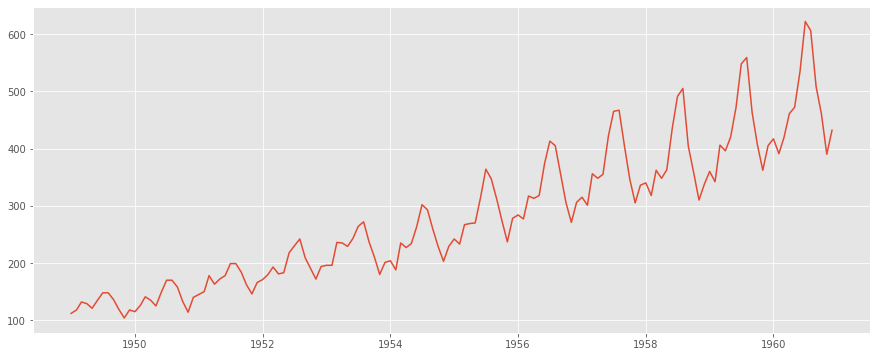

In [64]:
ts_log = np.log(ts)
plt.plot(ts)

Neste caso mais simples, é fácil ver para tendência futura nos dados. Mas não é muito intuitivo no caso de haver ruídos. Assim, podemos usar algumas técnicas para estimar ou modelar a tendência e, em seguida, removê-la da série. Podem haver muitas maneiras de fazer isso e algumas das mais comumente utilizadas são:

1- Agregação – usando a média para um período de tempo como médias semanais ou mensais

2- Suavização – usando médias moveis

3- Ajuste polinomial – encaixando um modelo de regressão

Vou usar suavização aqui, mas você deve tentar outras técnicas que podem funcionar para outros problemas. Suavização refere-se às estimativas contínuas, ou seja, considerando os últimos casos. Pode ser feito de várias maneiras, aqui vou discutir duas delas.

#### Média Movel

Consideramos a média de ‘K’ valores consecutivos, dependendo da frequência da série temporal.

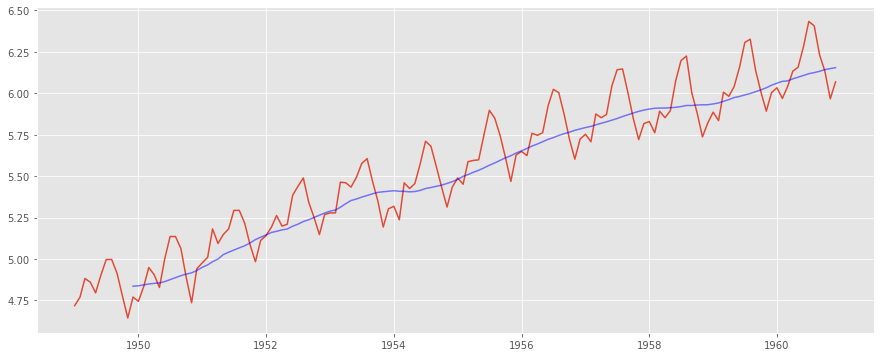

In [66]:
moving_avg = ts_log.rolling(window=12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='blue', alpha=0.5)
plt.show()

A linha azul mostra a média móvel. Iremos subtrair isso da série original. Note-se que uma vez que estamos tomando média dos últimos 12 valores, a média móvel não está definida para 11 primeiros valores. Isto pode ser observado como:

In [68]:
ts_log_moving_avg_diff  = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
Name: #Passengers, dtype: float64

Observe os primeiro 11 como sendo NaN. Vamos usar esses valores NaN para testar a estacionaridade.

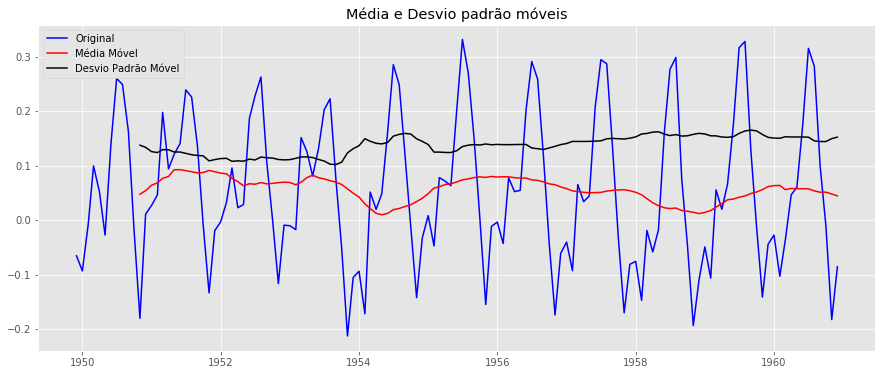

Resultados do teste Dickety-Fuller:
Teste Estatistico         -3.162908
p-value                    0.022235
#Lags Used                13.000000
Numero de observações    119.000000
Valor crítico (1%)        -3.486535
Valor crítico (5%)        -2.886151
Valor crítico (10%)       -2.579896
dtype: float64


In [69]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

Parece uma série muito melhor. Os valores parecem ter variado um pouco, mas não há nenhuma tendência específica. Além disso, a estatística do teste é menor do que os valores críticos de 5% para que possamos dizer com 95% de confiança que esta é uma série estacionária.

Uma desvantagem dessa abordagem particular é que o período de tempo tem que ser rigorosamente definido. Nesse caso, podemos tomar médias anuais, mas em situações complexas como previsão de um preço das ações, é difícil chegar a um número. Então vamos usar uma “média móvel ponderada”, onde aos valores mais recentes é dado um peso maior. Não há muitas técnicas para atribuição de pesos. Uma popular é a média ponderada exponencial onde pesos são atribuídos a todos os valores anteriores com um fator de decaimento em movimento.

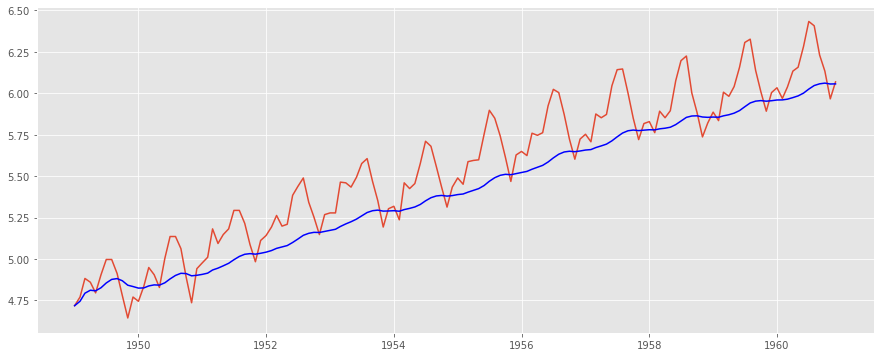

In [75]:
expwighted_avg = ts_log.ewm(halflife=12).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color = 'blue')
plt.show()